In [1]:
import gc
import cv2
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import DistilBertTokenizer
import matplotlib.pyplot as plt
import config as config
from train import build_dataloaders,make_train_valid_dfs
from CLIP import CLIPModel

In [2]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(config.text_tokenizer)
    valid_loader = build_dataloaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(config.device)
    model.load_state_dict(torch.load(model_path, map_location=config.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(config.device))
            image_embeddings = model.image_proj(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(config.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(config.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_proj(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    _, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    
    # Ensure that the indices do not exceed the length of image_filenames
    valid_indices = [idx for idx in indices[::5] if idx < len(image_filenames)]
    matches = [image_filenames[idx] for idx in valid_indices]
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{config.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

In [7]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "../models/clip_model.pt")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████| 506/506 [00:39<00:00, 12.70it/s]


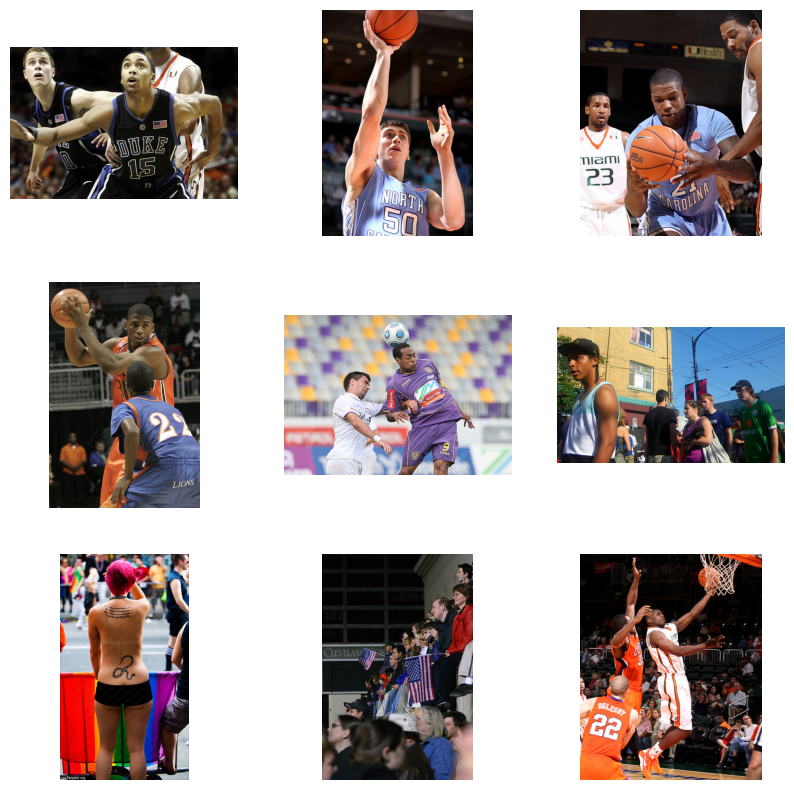

In [18]:
find_matches(model,
             image_embeddings,
             query="A boy with basketball",
             image_filenames=valid_df['image'].values,
             n=9)